In [1]:
#| hide
%load_ext autoreload
%autoreload 2

# mlforecast

> Scalable machine learning based time series forecasting.

**mlforecast** is a framework to perform time series forecasting using machine learning models, with the option to scale to massive amounts of data using remote clusters.

[![CI](https://github.com/Nixtla/mlforecast/actions/workflows/ci.yaml/badge.svg)](https://github.com/Nixtla/mlforecast/actions/workflows/ci.yaml)
[![Python](https://img.shields.io/pypi/pyversions/mlforecast)](https://pypi.org/project/mlforecast/)
[![PyPi](https://img.shields.io/pypi/v/mlforecast?color=blue)](https://pypi.org/project/mlforecast/)
[![conda-forge](https://img.shields.io/conda/vn/conda-forge/mlforecast?color=blue)](https://anaconda.org/conda-forge/mlforecast)
[![License](https://img.shields.io/github/license/Nixtla/mlforecast)](https://github.com/Nixtla/mlforecast/blob/main/LICENSE)

## Install

### PyPI

`pip install mlforecast`

If you want to perform distributed training, you can instead use `pip install mlforecast[distributed]`, which will also install [dask](https://dask.org/). Note that you'll also need to install either [LightGBM](https://github.com/microsoft/LightGBM/tree/master/python-package) or [XGBoost](https://xgboost.readthedocs.io/en/latest/install.html#python).

### conda-forge
`conda install -c conda-forge mlforecast`

Note that this installation comes with the required dependencies for the local interface. If you want to perform distributed training, you must install dask (`conda install -c conda-forge dask`) and either [LightGBM](https://github.com/microsoft/LightGBM/tree/master/python-package) or [XGBoost](https://xgboost.readthedocs.io/en/latest/install.html#python).

## How to use
The following provides a very basic overview, for a more detailed description see the [documentation](https://nixtla.github.io/mlforecast/).

Store your time series in a pandas dataframe in long format, that is, each row represents an observation for a specific serie and timestamp.

In [2]:
from mlforecast.utils import generate_daily_series

series = generate_daily_series(20)
series.head()

,ds,y
unique_id,,
id_00,2000-01-01,0.264447
id_00,2000-01-02,1.284022
id_00,2000-01-03,2.462798
id_00,2000-01-04,3.035518
id_00,2000-01-05,4.043565


Next define your models. If you want to use the local interface this can be any regressor that follows the scikit-learn API. For distributed training there are `LGBMForecast` and `XGBForecast`.

In [3]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

models = [
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]

Now instantiate a `Forecast` object with the models and the features that you want to use. The features can be lags, transformations on the lags and date features. The lag transformations are defined as [numba](http://numba.pydata.org/) *jitted* functions that transform an array, if they have additional arguments you supply a tuple (`transform_func`, `arg1`, `arg2`, ...).

In [4]:
from mlforecast import Forecast
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

fcst = Forecast(
    models=models,
    freq='D',
    lags=[7, 14],
    lag_transforms={
        1: [expanding_mean],
        7: [(rolling_mean, 7), (rolling_mean, 14)]
    },
    date_features=['dayofweek', 'month']
)

To compute the features and train the models call `fit` on your `Forecast` object. Here you have to specify the columns that:

* Identify each serie (`id_col`). If the series identifier is the index you can specify `id_col='index'`
* Contain the timestamps (`time_col`). Can also be integers if your data doesn't have timestamps.
* Are the series values (`target_col`)

In [5]:
fcst.fit(series, id_col='index', time_col='ds', target_col='y')

Forecast(models=[LGBMRegressor, XGBRegressor, RandomForestRegressor], freq=<Day>, lag_features=['lag-7', 'lag-14', 'expanding_mean_lag-1', 'rolling_mean_lag-7_window_size-7', 'rolling_mean_lag-7_window_size-14'], date_features=['dayofweek', 'month'], num_threads=1)

To get the forecasts for the next 14 days call `predict(14)` on the forecast object. This will automatically handle the updates required by the features using a recursive strategy.

In [6]:
predictions = fcst.predict(14)
predictions.head()

,ds,LGBMRegressor,XGBRegressor,RandomForestRegressor
unique_id,,,,
id_00,2000-08-10,5.226933,5.165335,5.244840
id_00,2000-08-11,6.222637,6.181697,6.258609
id_00,2000-08-12,0.212516,0.231710,0.225484
id_00,2000-08-13,1.236251,1.244750,1.228957
id_00,2000-08-14,2.241766,2.291263,2.302455


In [7]:
import pandas as pd
import numpy as np
from numba import njit

<AxesSubplot:>

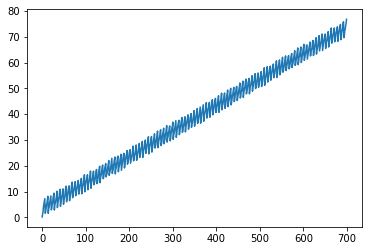

In [8]:
serie = pd.Series(0.1 * np.arange(700) + np.arange(7)[[x % 7 for x in np.arange(700)]] + np.random.rand(700))
serie.plot()

In [9]:
df = serie.to_frame('y')

In [10]:
df['ds'] = np.arange(serie.shape[0])
df.index = pd.Index(700 * [0])

In [15]:
fcst = Forecast(models=lgb.LGBMRegressor(), lags=[1], differences=[1, 7])
res = fcst.cross_validation(df, 4, 14).set_index('ds')
res[['y', 'LGBMRegressor']].plot();

IndexError: index 637 is out of bounds for axis 0 with size 637

In [16]:
debug

> /hdd/github/mlforecast/mlforecast/core.py(411)_transform()
    409         df = df.copy(deep=False)
    410         for feat in self.transforms.keys():
--> 411             df[feat] = self.features_[feat][self.restore_idxs]
    412 
    413         if dropna:



ipdb>  self.restore_idxs


array([   8,    9,   10,   11,   12,   13,   14,   15,   16,   17,   18,
         19,   20,   21,   22,   23,   24,   25,   26,   27,   28,   29,
         30,   31,   32,   33,   34,   35,   36,   37,   38,   39,   40,
         41,   42,   43,   44,   45,   46,   47,   48,   49,   50,   51,
         52,   53,   54,   55,   56,   57,   58,   59,   60,   61,   62,
         63,   64,   65,   66,   67,   68,   69,   70,   71,   72,   73,
         74,   75,   76,   77,   78,   79,   80,   81,   82,   83,   84,
         85,   86,   87,   88,   89,   90,   91,   92,   93,   94,   95,
         96,   97,   98,   99,  100,  101,  102,  103,  104,  105,  106,
        107,  108,  109,  110,  111,  112,  113,  114,  115,  116,  117,
        118,  119,  120,  121,  122,  123,  124,  125,  126,  127,  128,
        129,  130,  131,  132,  133,  134,  135,  136,  137,  138,  139,
        140,  141,  142,  143,  144,  145,  146,  147,  148,  149,  150,
        151,  152,  153,  154,  155,  156,  157,  1

ipdb>  q
